In [2]:
import os
import cv2
import torch
import pandas as pd
import copy
from skimage.util import random_noise
from torch.utils.data import Dataset
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import util
import easydict
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from datetime import datetime
from pathlib import Path
from PIL import Image

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print('Device : {}'.format(device))

args = easydict.EasyDict({
    "device": device,
    "mnist_fn": './data/old_data/train.csv',
    "resume": None,

    "lr": 1e-4,
    "batch_size": 64,
    "epochs": 2000,
    "patient": 15,

    "dataset_ratio": 0.7,
})

util.seed_everything(777)
assert os.path.isfile(args.mnist_fn), 'wrong path'
# assert os.path.isdir(args.train_data_file_dir), 'wrong path'
# assert os.path.isdir(args.test_data_file_dir), 'wrong path'
# assert os.path.isfile(args.train_data_answer_dir), 'wrong path'
# assert os.path.isfile(args.submission_file_dir), 'wrong path'

Device : cuda:1


In [3]:
class DirtyMnistGen(Dataset):    
    def __init__(self, fn='data/old_data/train.csv', transforms=None):        
        self.transforms = transforms
        df = pd.read_csv(fn)
        df = df.drop(['id', 'digit', 'letter'], axis=1).values
        df = df.reshape(-1, 28, 28) / 255.0

        img_original = []
        img_gaussian = []
        img_snp = []

        for idx in range(df.shape[0]):
            img = df[idx]
            dmy = np.zeros(shape=(256,256))

            scale = np.random.rand() * 3 + 0.5
            dsize = (int(img.shape[0] * scale), int(img.shape[1] * scale))
            # dsize = img.shape
            scaled_img = cv2.resize(
                img.astype('float32'),
                 dsize=dsize, 
                 interpolation=cv2.INTER_LINEAR,
                 )

            x = np.random.randint(0, dmy.shape[1] - dsize[1])
            y = np.random.randint(0, dmy.shape[0] - dsize[0])

            dmy[y:y+dsize[0], x:x+dsize[1]] = scaled_img
            gaussian_noise = random_noise(dmy, mode='gaussian', var=0.5)
            snp_noise = random_noise(dmy, mode='s&p', amount=0.35, salt_vs_pepper=0.4)

            img_original.append(dmy)
            img_gaussian.append(gaussian_noise)
            img_snp.append(snp_noise)

        img_original = np.array(img_original)
        img_gaussian = np.array(img_gaussian)
        img_snp = np.array(img_snp)

        self.train_x = np.concatenate([img_gaussian, img_snp], axis=0)
        self.train_y = np.concatenate([img_original, img_original], axis=0)
        
    def __len__(self):
        return self.train_x.shape[0]
    
    def __getitem__(self, idx):
        if self.transforms:
            train_x = self.transforms(self.train_x[idx])
            train_y = self.transforms(self.train_y[idx])
        else:
            train_x = self.train_x[idx]
            train_y = self.train_y[idx]
             
        return train_x, train_y

In [193]:
%%time
autoencoder_transforms = {
    'train' : transforms.Compose([
        transforms.ToTensor(),
        ]),
}

data_set = DirtyMnistGen(
    fn='data/old_data/train.csv',
    transforms=autoencoder_transforms['train']
)

Wall time: 344 ms


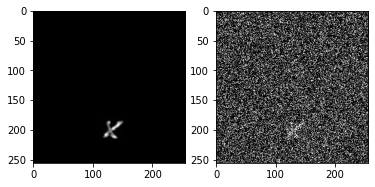

In [194]:
idx = np.random.randint(len(data_set))
train_x, train_y = data_set[idx]

train_x = transforms.ToPILImage()(train_x)
train_y = transforms.ToPILImage()(train_y)

plt.subplot(1,2,1)
plt.imshow(train_y, 'gray')
plt.subplot(1,2,2)
plt.imshow(train_x, 'gray')
plt.show()

In [4]:
autoencoder_transforms = {
    'train' : transforms.Compose([
        transforms.ToTensor(),
        ]),
}

data_set = DirtyMnistGen(
    fn='data/old_data/train.csv',
    transforms=autoencoder_transforms['train']
)

In [5]:
train_set_nb = int(len(data_set) * args.dataset_ratio)
valid_set_nb = len(data_set) - train_set_nb
train_set, val_set = torch.utils.data.random_split(data_set, [train_set_nb, valid_set_nb])

train_data_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size = args.batch_size,
        shuffle = True,
    )

valid_data_loader = torch.utils.data.DataLoader(
        val_set,
        batch_size = args.batch_size,
        shuffle = False,
    )

In [6]:
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder,self).__init__()

#         def encoder_block(dim):
#             block = nn.Sequential(
#                 nn.ReLU(),
#                 nn.BatchNorm2d(dim),
#                 nn.MaxPool2d(2,2)  
#             )
#             return block

#         def decoder_block(dim):
#             block = nn.Sequential(
#                 nn.ReLU(),
#                 nn.BatchNorm2d(dim),
#             )
#             return block

#         self.encoder = nn.Sequential(
#             nn.Conv2d(1,16,3,padding=1),                       # batch x 16 x 256 x 256
#             encoder_block(16),                                 # batch x 16 x 128 x 128
#             nn.Conv2d(16,32,3,padding=1),                      # batch x 32 x 64 x 64
#             encoder_block(32),                                 # batch x 32 x 32 x 32
#             nn.Conv2d(32,64,3,padding=1),                      # batch x 64 x 32 x 32
#             encoder_block(64),                                 # batch x 64 x 16 x 16
#             nn.Conv2d(64,128,3,padding=1),                     # batch x 128 x 32 x 32
#             encoder_block(128),                                # batch x 128 x 16 x 16
#             nn.Conv2d(128,256,3,padding=1),                    # batch x 256 x 32 x 32
#             encoder_block(256),                                # batch x 256 x 8 x 8
#         )

#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(256,128,3,2,1,1),               # batch x 128 x 16 x 16
#             decoder_block(128),
#             nn.ConvTranspose2d(128,64,3,2,1,1),                # batch x 128 x 16 x 16
#             decoder_block(64),
#             nn.ConvTranspose2d(64,32,3,2,1,1),
#             decoder_block(32),
#             nn.ConvTranspose2d(32,16,3,2,1,1),
#             decoder_block(16),
#             nn.ConvTranspose2d(16,1,3,2,1,1),
#             decoder_block(1),
#         )
                
#     def forward(self,x):
#         out = self.encoder(x)
#         out = self.decoder(out)
#         return out

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,16,3,padding=1),                            # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,32,3,padding=1),                           # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),                           # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)                                       # batch x 64 x 14 x 14
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),                          # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),                         # batch x 64 x 7 x 7
                        nn.ReLU()
        )
        
        self.layer3 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1),                    # batch x 128 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),                       # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer4 = nn.Sequential(
                        nn.ConvTranspose2d(64,16,3,1,1),                        # batch x 16 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,1,3,2,1,1),                       # batch x 1 x 28 x 28
                        nn.ReLU()
        )
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out

In [7]:
model = Autoencoder()
input = torch.rand(5, 1, 256, 256)
print(model(input).shape)

torch.Size([5, 1, 256, 256])


In [8]:
optimizer = torch.optim.Adam(model.parameters(), args.lr)
criterion = nn.MSELoss()

scheduler = ReduceLROnPlateau(
    optimizer=optimizer,
    mode='min',
    patience=2,
    factor=0.5,
    verbose=True
    )

train_error = []
valid_error = []

best_loss = float("inf")
best_loss_pos = None

patient = 0
patient_limit = args.patient

date_time = datetime.now().strftime("%m%d%H%M")
SAVE_DIR = os.path.join('./save', date_time) + '_autoencoder'
Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)

if(args.resume):
    model.load_state_dict(torch.load(args.resume))
    print('[info msg] pre-trained weight is loaded !!\n')        
    print(args.resume)
    print('=' * 50)

print('[info msg] training start !!\n')

startTime = datetime.now()
for epoch in range(args.epochs):        
    print('Epoch {}/{}'.format(epoch+1, args.epochs))
    train_loss = util.train(
        train_loader=train_data_loader,
        model=model,
        loss_func=criterion,
        device=args.device,
        optimizer=optimizer,
        )
    train_error.append(train_loss)

    valid_loss = util.validate(
        valid_loader=valid_data_loader,
        model=model,
        loss_func=criterion,
        device=args.device,
        scheduler=scheduler,
        )
    valid_error.append(valid_loss)        

    is_best = best_loss > valid_loss

    if is_best:
        patient = 0
        best_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(SAVE_DIR, 'model_best.pth.tar'))
        print('MODEL SAVED!')
        
    else:
        patient += 1
        if patient > patient_limit - 1:
            print('=======' * 10)
            print("[Info message] Early stopper is activated")
            break

elapsed_time = datetime.now() - startTime

train_error = np.array(train_error)
valid_error = np.array(valid_error)
best_loss_pos = np.argmin(valid_error)

print('=' * 50)
print('[info msg] training is done\n')
print("Time taken: {}".format(elapsed_time))
print("best loss is {} at epoch : {}".format(best_loss, best_loss_pos))

print('=' * 50)
print('[info msg] model weight and log is save to {}\n'.format(SAVE_DIR))

with open(os.path.join(SAVE_DIR, 'log.txt'), 'w') as f:
    for key, value in vars(args).items():
        f.write('{} : {}\n'.format(key, value))            

    f.write('time taken : {}\n\n'.format(str(elapsed_time)))
    f.write('best_train_loss at {} epoch : {}\n'.format(np.argmin(train_error), np.min(train_error)))
    f.write('best_valid_loss at {} epoch : {}\n'.format(np.argmin(train_error), np.min(valid_error)))

plt.plot(train_error, label='train loss')
plt.plot(valid_error, 'o', label='valid loss')
plt.axvline(x=best_loss_pos, color='r', linestyle='--', linewidth=1.5)
plt.legend()
plt.savefig(os.path.join(SAVE_DIR, 'history.png'))
plt.show()

.97it/s, loss - 0.000388]
Valid: 100%|██████████| 20/20 [00:03<00:00,  5.36it/s, loss - 0.000391]
MODEL SAVED!
Epoch 35/2000
Valid: 100%|██████████| 20/20 [00:03<00:00,  5.36it/s, loss - 0.000397]
Epoch 36/2000
Valid: 100%|██████████| 20/20 [00:03<00:00,  5.25it/s, loss - 0.000382]
MODEL SAVED!
Epoch 37/2000
Valid: 100%|██████████| 20/20 [00:03<00:00,  5.33it/s, loss - 0.000376]
MODEL SAVED!
Epoch 38/2000
Valid: 100%|██████████| 20/20 [00:03<00:00,  5.35it/s, loss - 0.000373]
MODEL SAVED!
Epoch 39/2000
Valid: 100%|██████████| 20/20 [00:03<00:00,  5.36it/s, loss - 0.000377]
Epoch 40/2000
Valid: 100%|██████████| 20/20 [00:03<00:00,  5.31it/s, loss - 0.000369]
MODEL SAVED!
Epoch 41/2000
Valid: 100%|██████████| 20/20 [00:03<00:00,  5.29it/s, loss - 0.000361]
MODEL SAVED!
Epoch 42/2000
Valid: 100%|██████████| 20/20 [00:03<00:00,  5.34it/s, loss - 0.000362]
Epoch 43/2000
Valid: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s, loss - 0.000367]
Epoch 44/2000
Valid: 100%|██████████| 20/20 [00:03

KeyboardInterrupt: 

In [9]:
iterator = iter(valid_data_loader) 

[]

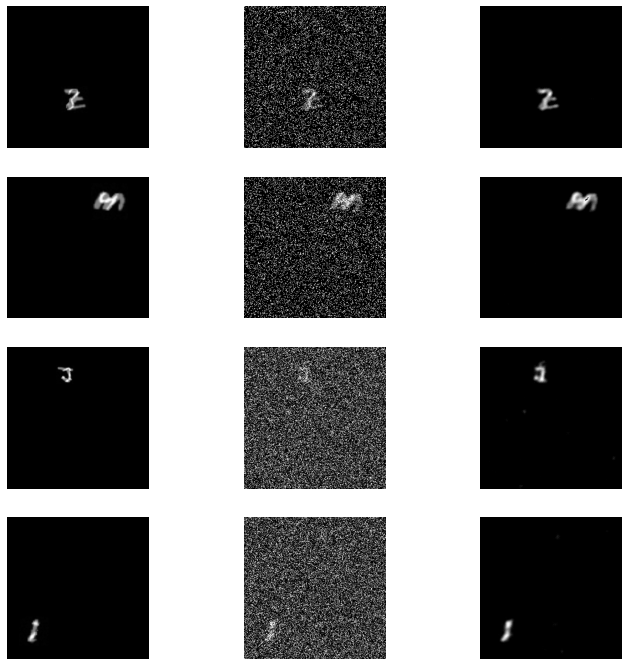

In [10]:
valid_x, valid_y = next(iterator)
valid_x = valid_x[:4]
valid_y = valid_y[:4]
valid_x_t = valid_x.float().to(args.device)

model.to(args.device)
model.eval()
pred_y = model(valid_x_t)

plt.figure(figsize=(12,12))

for idx in range(4):
    noisy_img = transforms.ToPILImage()(valid_x[idx])
    ori_img = transforms.ToPILImage()(valid_y[idx])
    recovered_img = transforms.ToPILImage()(pred_y[idx])   

    plt.subplot(4,3,1 + idx * 3)
    plt.axis('off')
    plt.imshow(ori_img, 'gray')
    plt.subplot(4,3,2 + idx * 3)
    plt.axis('off')
    plt.imshow(noisy_img,'gray')
    plt.subplot(4,3,3 + idx * 3)
    plt.axis('off')
    plt.imshow(recovered_img,'gray')
    
plt.plot()

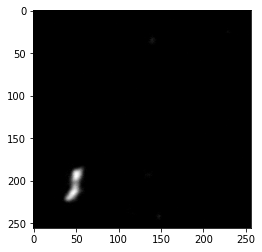

In [11]:
plt.imshow(recovered_img, 'gray')

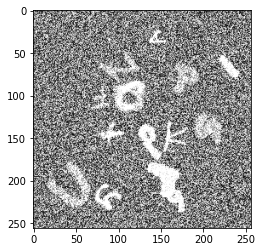

In [3]:
sample = cv2.imread('tt.png', cv2.IMREAD_GRAYSCALE) / 255.0
plt.imshow(sample, 'gray')

In [17]:
sample_t = torch.tensor(sample, dtype=torch.float, device=args.device)
sample_t = torch.unsqueeze(torch.unsqueeze(sample_t, dim=0), dim=0)
pred_t = model(sample_t)

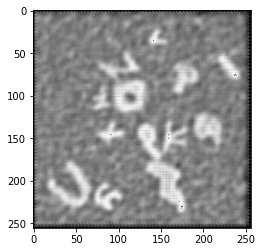

In [20]:
pred = transforms.ToPILImage()(torch.squeeze(pred_t))
plt.imshow(pred, 'gray')

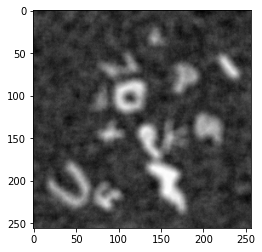

In [8]:
import cv2
blur = cv2.bilateralFilter(sample.astype('float32'), 12, 30, 75)
plt.imshow(blur, 'gray')

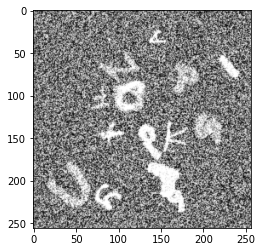

In [22]:
blur = cv2.GaussianBlur(sample.astype('float32'), (3,3), 0.5)
plt.imshow(blur, 'gray')

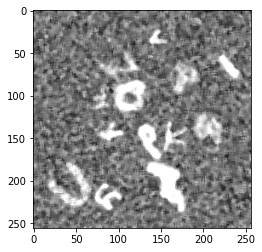

In [25]:
blur = cv2.medianBlur(sample.astype('float32'), 5)
plt.imshow(blur, 'gray')

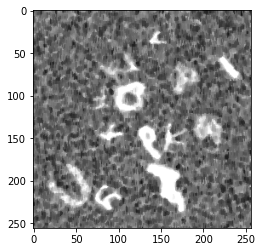

In [37]:
erosion = cv2.erode(blur.astype('float32'), (5,5),iterations = 2)
plt.imshow(erosion, 'gray')

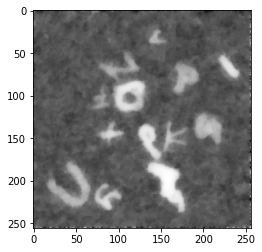

In [5]:
import skimage
from skimage.restoration import *
plt.imshow(skimage.restoration.denoise_tv_bregman(sample, 0.6), 'gray')

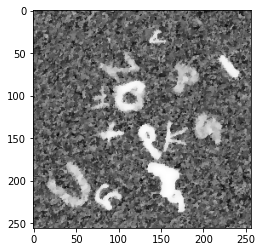

In [72]:
from skimage.restoration import *
plt.imshow(skimage.restoration.denoise_tv_chambolle(sample, 0.14), 'gray')

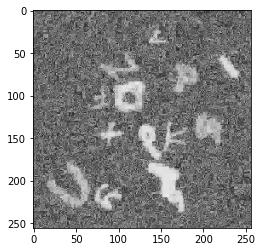

In [88]:
plt.imshow(skimage.restoration.denoise_wavelet(sample, 0.22), 'gray')

In [35]:
from skimage import restoration
from PIL import Image

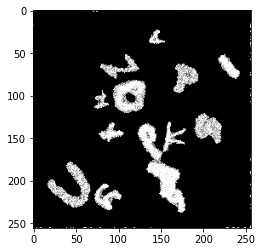

In [57]:
sample = Image.open('tt.png').convert('RGB')
gray_sample = sample.convert('L')
test_img = restoration.denoise_tv_bregman(gray_sample, 0.6)
_, bin = cv2.threshold((test_img*255).astype('uint8'), 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
fimg = cv2.bitwise_and(np.array(sample), np.array(sample), mask=bin)
plt.imshow(fimg, 'gray')

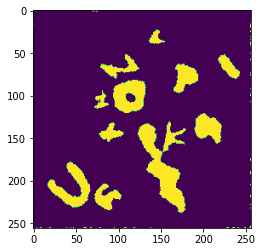

In [49]:

plt.imshow(bin)

In [202]:
class DatasetMNIST(torch.utils.data.Dataset):
    def __init__(self, image_folder, label, transforms=None):        
        self.image_folder = image_folder   
        self.label = pd.read_csv(label)
        self.transforms = transforms

    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, index):        
        image_fn = self.image_folder +\
            str(self.label.iloc[index,0]).zfill(5) + '.png'
                                              
        # image = Image.open(image_fn).convert('RGB')
        image = Image.open(image_fn).convert('RGB')
        gray_sample = image.convert('L')
        f_image = restoration.denoise_tv_bregman(gray_sample, 0.6)
        _, bin = cv2.threshold((f_image*255).astype('uint8'), 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        image = cv2.bitwise_and(np.array(image), np.array(image), mask=bin) / 255.0
        
        label = self.label.iloc[index,1:].values.astype('float')

        if self.transforms:
            image = self.transforms(image)

        return image, label

mnist_transforms_value ={
    'mean' : [0.485, 0.456, 0.406],
    'std' : [0.229, 0.224, 0.225],
}

mnist_transforms = {
    'train' : transforms.Compose([
        # transforms.RandomHorizontalFlip(p=0.5),
        # transforms.RandomVerticalFlip(p=0.5),
        # transforms.ColorJitter(brightness=(0.2, 3), contrast=(0.2, 3), saturation=(0.2, 3), hue=(-0.5, 0.5)),
        # transforms.RandomPerspective(),   
        transforms.ToTensor(),
        transforms.Normalize(mnist_transforms_value['mean'],
                             mnist_transforms_value['std']),
        ]),
    'valid' : transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mnist_transforms_value['mean'],
                             mnist_transforms_value['std']),
        ]),
    'test' : transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mnist_transforms_value['mean'],
                             mnist_transforms_value['std']),
        ]),
}

In [203]:
data_set = DatasetMNIST(
        image_folder="./data/dirty_mnist_2nd/",
        label="./data/dirty_mnist_2nd_answer.csv",
        transforms=mnist_transforms['train']
    )

tensor(2.6400, dtype=torch.float64)


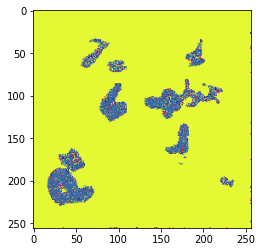

In [204]:
idx = np.random.randint(len(data_set))
train_x, train_y = data_set[idx]
print(torch.max(train_x))

train_x = transforms.ToPILImage()(train_x)
train_x = np.array(train_x)
# train_y = transforms.ToPILImage()(train_y)

# plt.subplot(1,2,1)
# plt.imshow(train_y, 'gray')
# plt.subplot(1,2,2)
# plt.imshow(train_x, 'gray')
# plt.show()
plt.imshow(train_x, 'gray')

In [205]:
np.max(train_x)

255